In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from utils import prep_zeng
%matplotlib inline

/Users/derek_howard/miniconda3/envs/py38/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
figure_dir = Path('./figures')
figure_dir.mkdir(exist_ok=True)

def load_data():
    # merges Zeng annotations to Triplet gene level embeddings
    zeng = prep_zeng()
    df_gene = pd.read_csv('./data/embeddings/final_model_trained_on_all_cortex_data_with_sz_genes/1603427156_triplet_all_training_embeddings_gene_level_with_info.csv',
                     index_col='gene_symbol')
    full_df = df_gene.merge(zeng, on='entrez_id', how='left')
    return full_df.dropna(subset=['gene_symbol']).set_index('gene_symbol').drop('entrez_id', axis=1).drop_duplicates()


def fit_umap(data, n_neighbors=15, min_dist=0.1, metric="euclidean", title=""):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric=metric
    )
    
    u = fit.fit_transform(data.iloc[:, :128])
    
    u_df = pd.DataFrame(u, columns=["x", "y"], index=data.index)
    
    annotation_cols = data.iloc[:, 128:].columns
    umap_data = pd.concat([u_df, data.loc[:, annotation_cols]], axis=1)
    for col in annotation_cols:
        umap_data[col] = umap_data[col].astype('category')
        
    return umap_data
    

In [3]:
# try to figure out why does data have 1088 rows?
# there were 1004 rows for gene embeddings
# and 995 unique entrez_ids in zeng_data
# how does a left join increase the total number of rows?
data = load_data()

/Users/derek_howard/projects/Human_Brain_ISH_ML/utils.py:5: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  zeng = pd.read_excel('./data/raw/Table S2.xlsx', header=[1], usecols=['Gene symbol', 'Entrez Gene ID', 'pattern description for Fig 2', 'level description for Fig 2', 'Cortical marker (human)', 'Level'])


In [4]:
umap_data = fit_umap(data=data)

/Users/derek_howard/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


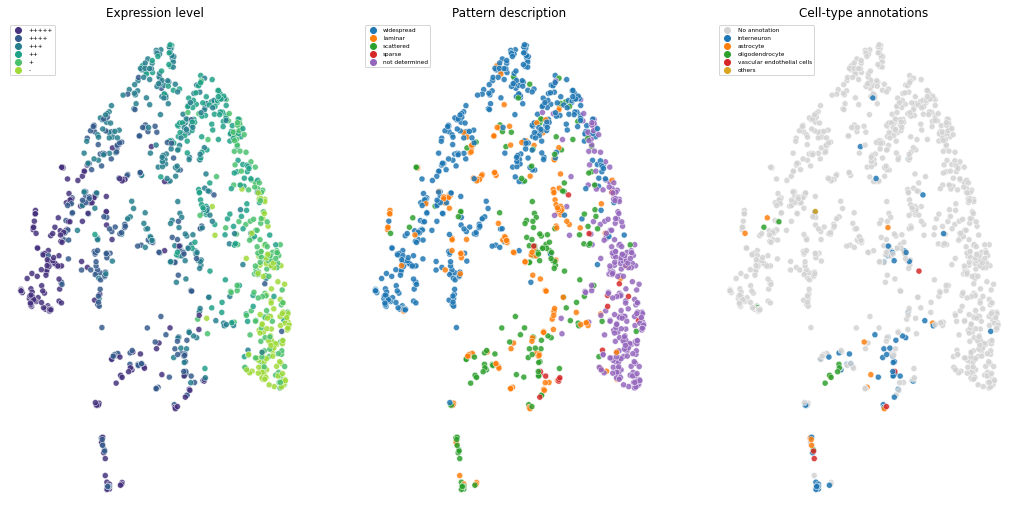

In [5]:
celltype_color_dict = {
    'No annotation': 'lightgrey',
    'interneuron': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    'astrocyte': (1.0, 0.4980392156862745, 0.054901960784313725),
    'oligodendrocyte': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
    'vascular endothelial cells': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
    'others': 'goldenrod'
}

celltype_hue_order = ['No annotation', 'interneuron', 'astrocyte', 'oligodendrocyte', 'vascular endothelial cells', 'others']

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize=(18, 9))

sns.scatterplot(data=umap_data, x='x', y='y', hue='expression_level', ax=ax1, palette='viridis', alpha=0.85)
sns.scatterplot(data=umap_data, x='x', y='y', hue='pattern_description', ax=ax2, alpha=0.85)
sns.scatterplot(data=umap_data, x='x', y='y', hue='celltype_markers', ax=ax3, palette=celltype_color_dict, hue_order=celltype_hue_order, alpha=0.85)
sns.despine(left=True, bottom=True)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

plt.setp((ax1,ax2, ax3), xticks=[], yticks=[])
ax1.title.set_text('Expression level')

ax1.legend(loc=2, fontsize='xx-small')
ax1.set_ylabel('')    
ax1.set_xlabel('')

ax2.title.set_text('Pattern description')
ax2.legend(loc=2, fontsize='xx-small')
ax2.set_ylabel('')    
ax2.set_xlabel('')

ax3.title.set_text('Cell-type annotations')
ax3.legend(loc=2, fontsize='xx-small');
ax3.set_ylabel('')    
ax3.set_xlabel('');

fig.savefig(figure_dir / 'umap_3panels.pdf', bbox_inches="tight", dpi=300);

# Visualize image level embeddings
plot embeddings and compare samples from visual cortex vs temporal cortex

In [6]:
img_info = pd.read_csv('./data/human_ISH_info.csv')
img_info = img_info.loc[:, ['image_id', 'region']]

In [7]:
img_info.region.value_counts()

Temporal cortex    11899
Visual cortex      11359
Name: region, dtype: int64

In [8]:
img_embeddings = pd.read_csv('./data/embeddings/final_model_trained_on_all_cortex_data_with_sz_genes/triplet_all_training_embeddings_image_level.csv',
                             index_col='image_id')

In [9]:
emb_df = img_embeddings.merge(img_info, left_index=True, right_on='image_id').set_index('image_id')

In [10]:
%%time
plot_data = fit_umap(data=emb_df.iloc[:,:128])

CPU times: user 55.2 s, sys: 1.91 s, total: 57.1 s
Wall time: 38.1 s


In [11]:
plot_data['region'] = emb_df.region.values

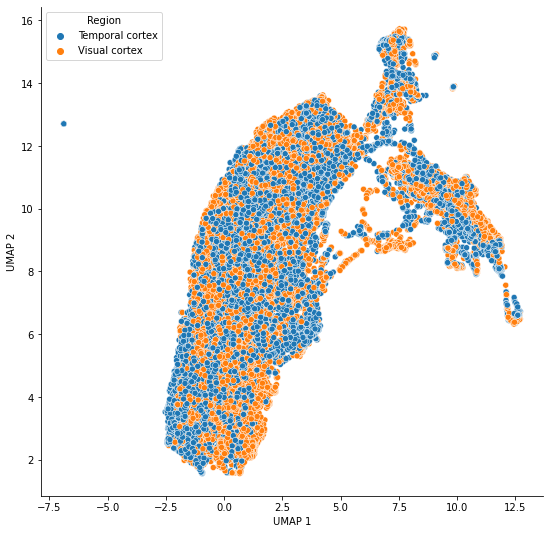

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(9,9))

sns.scatterplot(data=plot_data, x='x', y='y', hue='region', ax=ax)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
sns.despine()
legend = ax.get_legend()
legend.set_title('Region')


fig.savefig(figure_dir / 'img_umap-temporal_vs_visual.pdf', bbox_inches="tight", dpi=300);